# **This is the Sentiment Analysis of the Webex's app reviews [Jupyter Notebook]**
### We will see how to prepare the scraped dataset and insert it into machine learning models in order to do the right predictions.
### After training the models, we are going to evaluate them and measure their effeciency on classifying each review to the right class by distinguishing the right sentiment.

### The machine learning models we are going to use are **Logistic Regression**, **SGD Classifier** and **Naive Bayes**.

Firstly, we have to import the necessary libraries

*Tip: You might need to install some packages with the pip installer to import all the libraries*

In [1]:
# basic data handling and math libraries
import numpy as np
import pandas as pd
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# wordcloud library for visualizing most common words
from wordcloud import WordCloud, STOPWORDS
# regular expressions
import re, string, unicodedata
#Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
# textblob for spelling correction
from textblob import TextBlob, Word
# spacy for lemmatization
import spacy
# Scikit-learn libraries for feature extraction and modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
# for saving models
import joblib # How to use?: joblib.dump(model, 'model.pkl'), joblib.load('model.pkl')
# to ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

### For the first step, we are gonna import the data that we created in the previous notebook, in **DataFrame** format

In [2]:
webex_df = pd.read_csv('com.cisco.webex.meetings_reviews.csv')
webex_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,56598e3f-86f2-44ff-a561-4f6d58eb7173,Wendy Rowe,This is my second time trying it on my Android...,1,6,44.9.1,2024-10-16 18:12:56,44.9.1
1,2dd162df-044c-4129-a49b-dac5f80f037d,Will Power,The only disappointing aspect of this app is t...,3,1,44.9.1,2024-11-18 18:26:20,44.9.1
2,06fd6a83-ea69-4a75-af45-93f62e4adc27,Robert Jim Fulner,My company recently update the version of the ...,3,12,44.7.1,2024-08-18 15:18:44,44.7.1
3,7c9e80a3-8d54-4c4e-be76-1a045bb4f73c,Pthom Thompson,Display icons on the screen that do not have l...,3,8,44.7.0,2024-07-19 16:40:28,44.7.0
4,d683473f-fc6b-4aca-a650-4b82f24490aa,Andre Reyes,WebEx is pretty easy to use and has great vide...,4,51,44.6.1,2024-06-05 23:09:16,44.6.1


### Now we are going to perform some **Exploratory Data Analysis (EDA)**

In [3]:
webex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20099 entries, 0 to 20098
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20099 non-null  object
 1   userName              20099 non-null  object
 2   content               20099 non-null  object
 3   score                 20099 non-null  int64 
 4   thumbsUpCount         20099 non-null  int64 
 5   reviewCreatedVersion  18516 non-null  object
 6   at                    20099 non-null  object
 7   appVersion            18516 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.2+ MB


In [4]:
webex_df.describe()

,score,thumbsUpCount
count,20099.000000,20099.000000
mean,3.368327,7.668242
std,1.537540,66.900692
min,1.000000,0.000000
25%,2.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,1.000000
max,5.000000,3180.000000


In [5]:
webex_df['score'].value_counts()

score
5    6756
4    4301
1    4252
3    2884
2    1906
Name: count, dtype: int64

In [6]:
webex_df.isnull().sum()

reviewId                   0
userName                   0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    1583
at                         0
appVersion              1583
dtype: int64

### Now we have to keep only the important features for the sentiment analysis task, which are the review strings and the score.
*for a more obvious feature separation, we are also going to keep the scores 1 and 5 (negative, positive) only*

In [7]:
webex_df = webex_df[['content', 'score']]
webex_df['score'] = webex_df['score'].apply(lambda x: 'positive' if x >= 4 else('negative' if x <= 2 else 'neutral'))

webex_df['score'].value_counts()

score
positive    11057
negative     6158
neutral      2884
Name: count, dtype: int64

In [8]:
webex_df = webex_df[(webex_df['score'] == 'positive') | (webex_df['score'] == 'negative')]

webex_df['score'].value_counts()

score
positive    11057
negative     6158
Name: count, dtype: int64

In [9]:
webex_df.shape

(17215, 2)

## Now we are moving to the text's normalization
- ### First we use the `ToktokTokenizer` to break text into individual tokens while preserving important linguistic features.
- ### Then we create a list of English stop words using the `nltk` library in order to remove these words and help focus on the meaningful content that actually express sentiment.

In [10]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

### To remove special characters:

In [11]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-Z\s]' if remove_digits else r'[^a-zA-Z0-9\s]'
    return re.sub(pattern, '', text)

webex_df['content'] = webex_df['content'].apply(lambda x: remove_special_characters(x))

In [12]:
webex_df['content'].iloc[1]

'WebEx is pretty easy to use and has great video and microphone abilities However it tends to drop your video whenever you get any calls or notifications during the meeting even if you put your phone on Do Not Disturb Which may be user error Other than that I have no issues with it'

### Lemmatization 
**!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

(*We can skip because classifiers can learn word-sentiment relashionships directly from the labeled data and modern deep learning models can handle word variations well*)

In [13]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#
## Get wordnet POS tag
#def get_wordnet_pos(word):
#    tag = nltk.pos_tag([word])[0][1][0].upper()
#    tag_dict = {"J": wordnet.ADJ,
#                "N": wordnet.NOUN,
#                "V": wordnet.VERB,
#                "R": wordnet.ADV}
#    return tag_dict.get(tag, wordnet.NOUN)
#
## Lemmatization function
#def lemmatize_text(text):
#    lemmatizer = WordNetLemmatizer()
#    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
#                    for word in text.split()])
#
#webex_df['content'] = webex_df['content'].apply(lemmatize_text)

### Removing Stopwords

**!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

(*We can skip this too*)

In [14]:
##set stopwords to english
#stop=set(stopwords.words('english'))
#print(stop)
#
##removing the stopwords
#def remove_stopwords(text, is_lower_case=False):
#    tokens = tokenizer.tokenize(text)
#    tokens = [token.strip() for token in tokens]
#    if is_lower_case:
#        filtered_tokens = [token for token in tokens if token not in stopword_list]
#    else:
#        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#    filtered_text = ' '.join(filtered_tokens)    
#    return filtered_text
##Apply function on review column
#webex_df['content']=webex_df['content'].apply(remove_stopwords)
#
#webex_df['content'].iloc[1]

### Now we will split the data into training set, validation set and test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(webex_df['content'], webex_df['score'], test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print (f'Training Data Shape: {X_train.shape} \nTesting Data Shape: {X_test.shape}')

Training Data Shape: (13772,) 
Testing Data Shape: (3443,)


In [16]:
for i in range(8):
    print(f"Review: {X_train.iloc[i]} \nSentiment: {y_train.iloc[i]} \n")

Review: Works great for listening in but people said my voice was very low volume compared to when I use the same headset connected to a laptop and joining via that 
Sentiment: positive 

Review: Great facility Great audio  video quality Very easy seamless download on Android device 
Sentiment: positive 

Review: Love the app no kidding But when your in the meetings the sound is horrible Id like it mif you could mute people for you 
Sentiment: positive 

Review: This app hacked my phone and now my new phone is not working at all  who will give me the money back of the phone  This a disguising app not install it can hack your phone and your phone will not work at all after that Even whatsapp call is better than this 
Sentiment: negative 

Review: Cant even use Bluetooth properly Zoom BlueJeans Skype all work fine with Bluetooth 
Sentiment: negative 

Review: Must have screen rotation option 
Sentiment: negative 

Review: Crisp quality relatively low battery use and low bandwidth require

## **BoW**: Bag of Words modelling
### We use this to convert text documents to numerical vectors / bag of words

In [17]:
# Count vectorizer for bag of words
cv = CountVectorizer(min_df=1, max_df=1.0, binary=False, ngram_range=(1, 3))

# transformed train reviews
cv_train_reviews = cv.fit_transform(X_train)

# transformed validation reviews
#cv_val_reviews = cv.transform(X_val)

# transformed test reviews
cv_test_reviews = cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
#print('BOW_cv_val:',cv_val_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (13772, 385939)
BOW_cv_test: (3443, 385939)


In [18]:
#Tfidf vectorizer
tv = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True, ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)

# transformed validation reviews
#tv_val_reviews = tv.transform(X_val)

#transformed test reviews
tv_test_reviews=tv.transform(X_test)

print('Tfidf_train:',tv_train_reviews.shape)
#print('Tfidf_val:',tv_val_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (13772, 385939)
Tfidf_test: (3443, 385939)


### Labeling the sentiment text

In [19]:
#labeling the sentient data
lb=LabelBinarizer()

#transformed sentiment data
train_sentiments=lb.fit_transform(y_train)
#val_sentiments=lb.transform(y_val)
test_sentiments=lb.transform(y_test)

print(train_sentiments, train_sentiments.shape)
#print(val_sentiments, val_sentiments.shape)
print(test_sentiments, test_sentiments.shape)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]] (13772, 1)
[[1]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]] (3443, 1)


# **Logistic Regression**

## GridSearchCV

In [20]:
# C_range = np.linspace(0.01, 1, 100)
# C_range = C_range.tolist()
# #
# parameters ={'C': C_range,
#              'penalty':['l1', 'l2', 'elasticnet'],
#              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
#              'max_iter':[100, 1000, 2500, 5000],
#              'random_state':[42]}

In [21]:
# lr=LogisticRegression()
# lr

In [ ]:
# C_range = np.linspace(0.1, 1, 10)
# C_range = C_range.tolist()
# #
# parameters ={'C': C_range,
#              'penalty':['l1', 'l2', 'elasticnet'],
#              'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
#              'max_iter':[100, 500, 1000, 2500, 5000]
#              }

In [ ]:
# lr=LogisticRegression()
# lr

LogisticRegression()

In [ ]:
# lr_bow = GridSearchCV(lr, param_grid=parameters, cv=5)
# lr_bow.fit(cv_train_reviews, y_train)
# print(lr_bow, lr_bow.best_params_)

## By utilizing GridSearch, we found the best parameters for fitting Logistic Regression to the training set

## Training

In [50]:
#training the model
lr=LogisticRegression(penalty='l2', max_iter=100, C=0.8, solver='saga', random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=0.8, random_state=42, solver='saga')
LogisticRegression(C=0.8, random_state=42, solver='saga')


## Testing

In [51]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 0 1 ... 0 0 0]
[1 0 1 ... 0 1 0]


## accuracy

In [52]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8469358117920418
lr_tfidf_score : 0.8934069125762416


## Classification Report

In [60]:
# Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Negative','Positive'])
print(lr_bow_report)

# Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Negative','Positive'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.73      0.91      0.81      1234
    Positive       0.94      0.81      0.87      2209

    accuracy                           0.85      3443
   macro avg       0.84      0.86      0.84      3443
weighted avg       0.87      0.85      0.85      3443

              precision    recall  f1-score   support

    Negative       0.89      0.81      0.84      1234
    Positive       0.90      0.94      0.92      2209

    accuracy                           0.89      3443
   macro avg       0.89      0.87      0.88      3443
weighted avg       0.89      0.89      0.89      3443



## Confusion Matrix

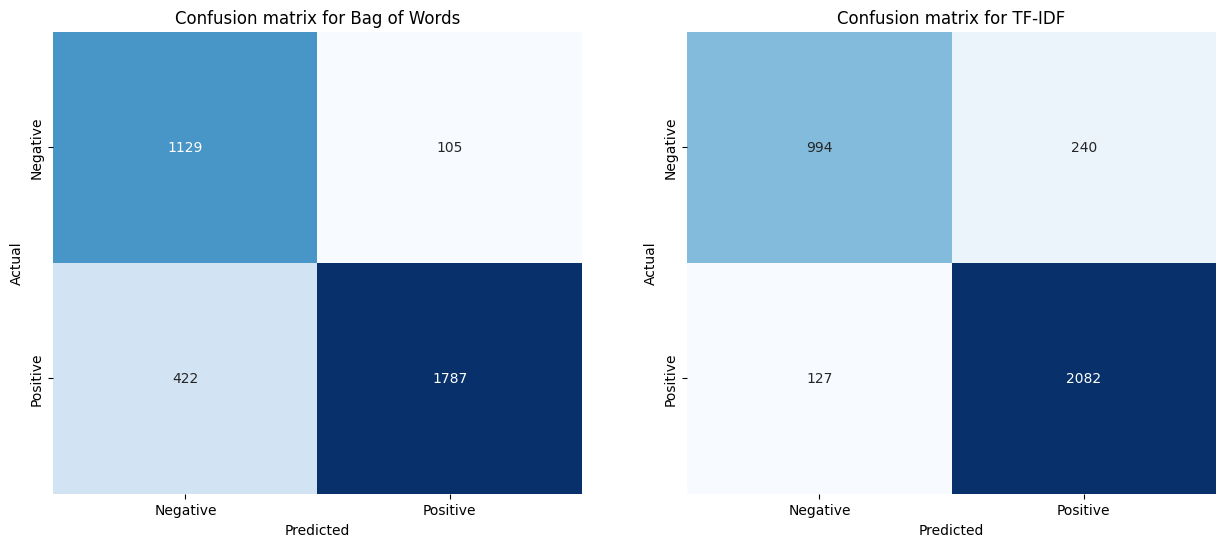

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow=confusion_matrix(test_sentiments,lr_bow_predict)
# create heatmap
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion matrix for Bag of Words')

cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion matrix for TF-IDF')

plt.show()


# **Stohastic Gradient Descent Model**

## Training 

In [105]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=100,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews, train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews, train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=100, random_state=42)
SGDClassifier(max_iter=100, random_state=42)


## Testing

In [106]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
##Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]


## Accuracy

In [107]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.8710426953238455
svm_tfidf_score : 0.9050246877722916


## Classification Report

In [108]:
# Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Negative','Positive'])
print(svm_bow_report)

# Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Negative','Positive'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.77      0.91      0.84      1234
    Positive       0.95      0.85      0.89      2209

    accuracy                           0.87      3443
   macro avg       0.86      0.88      0.86      3443
weighted avg       0.88      0.87      0.87      3443

              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      1234
    Positive       0.92      0.93      0.93      2209

    accuracy                           0.91      3443
   macro avg       0.90      0.90      0.90      3443
weighted avg       0.90      0.91      0.90      3443



## Confusion Matrix

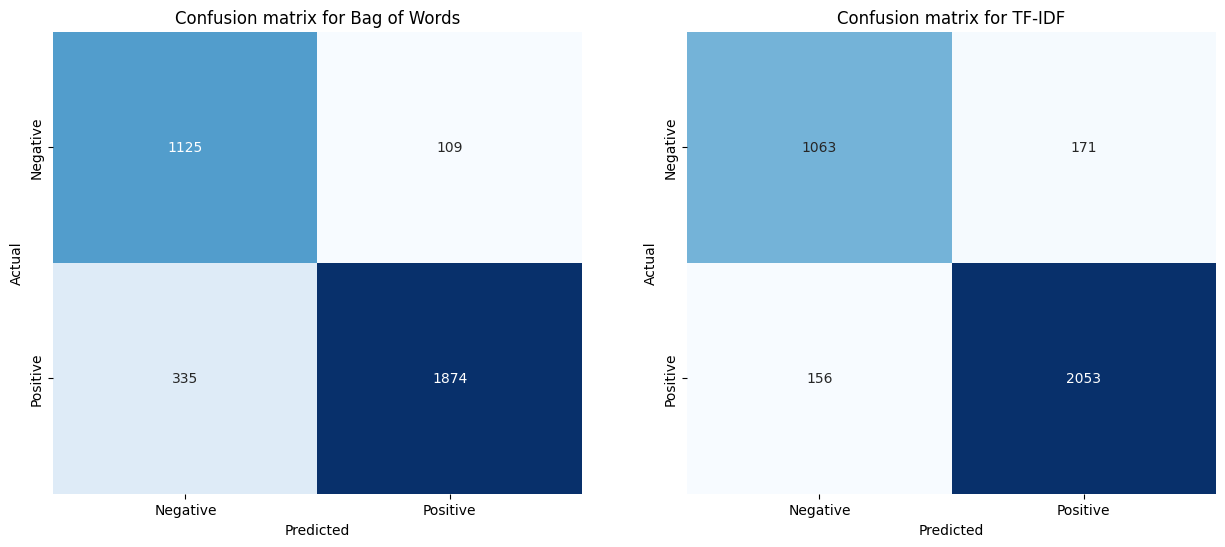

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow2=confusion_matrix(test_sentiments,svm_bow_predict)
# create heatmap
sns.heatmap(cm_bow2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion matrix for Bag of Words')

cm_tfidf2=confusion_matrix(test_sentiments,svm_tfidf_predict)
sns.heatmap(cm_tfidf2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion matrix for TF-IDF')

plt.show()

# **Multinomial Naive Bayes Model**

## Training

In [110]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


## Testing

In [111]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]


## Accuracy

In [112]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.740923613128086
mnb_tfidf_score : 0.740923613128086


## Classification Report

In [114]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Negative','Positive'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Negative','Positive'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.98      0.28      0.44      1234
    Positive       0.71      1.00      0.83      2209

    accuracy                           0.74      3443
   macro avg       0.85      0.64      0.63      3443
weighted avg       0.81      0.74      0.69      3443

              precision    recall  f1-score   support

    Negative       0.98      0.28      0.44      1234
    Positive       0.71      1.00      0.83      2209

    accuracy                           0.74      3443
   macro avg       0.85      0.64      0.64      3443
weighted avg       0.81      0.74      0.69      3443



## Confusion Matrix

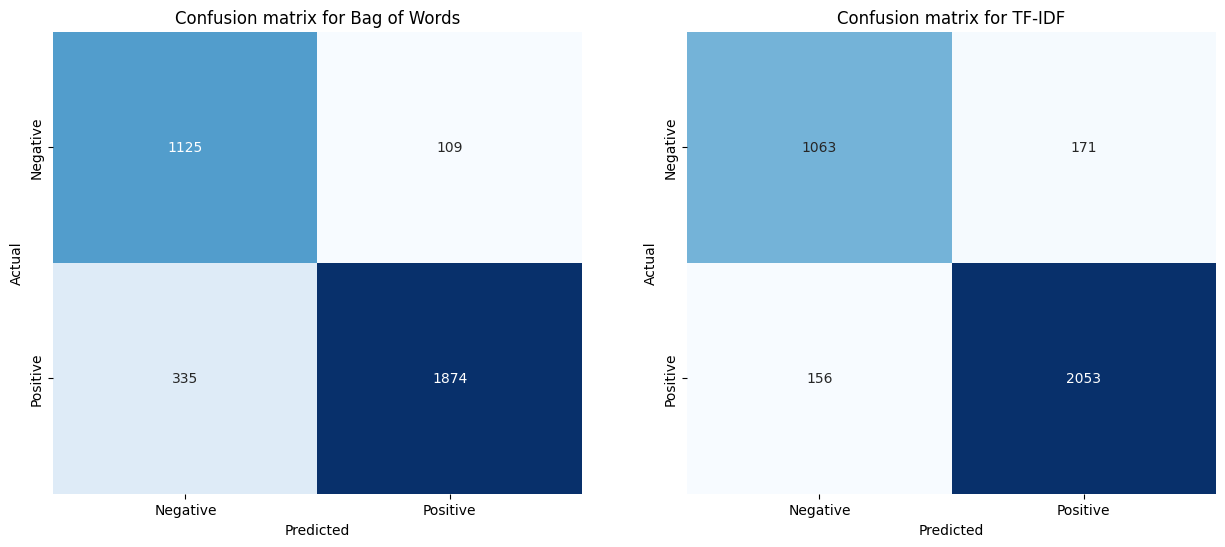

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow3=confusion_matrix(test_sentiments,mnb_bow_predict)
# create heatmap
sns.heatmap(cm_bow2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion matrix for Bag of Words')

cm_tfidf3=confusion_matrix(test_sentiments,mnb_tfidf_predict)
sns.heatmap(cm_tfidf2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion matrix for TF-IDF')

plt.show()